# Определение возраста покупателей

## Исследовательский анализ данных

In [8]:
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np

Загрузим данные

In [11]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Посмотрим размер выборки

In [9]:
print(labels.shape)

(7591, 2)


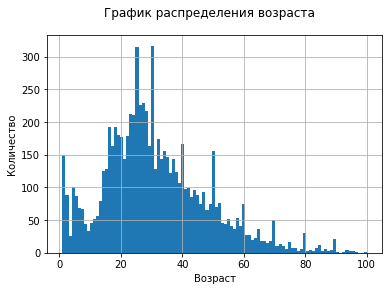

In [28]:
import matplotlib.pyplot as plt
plot = labels.real_age.hist(bins = 100);
plt.suptitle('График распределения возраста');
plot.set_xlabel("Возраст");
plot.set_ylabel("Количество");
plt.show()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Мода =  0    30
dtype: int64


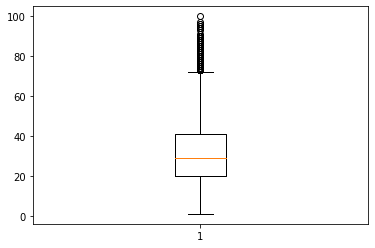

In [40]:
display(labels.describe())
plt.boxplot(labels["real_age"])
print('Мода = ',labels["real_age"].mode())

Больше всего лиц в районе 30 и 25 лет. Есть значения под 100. Распределение смещено влево.

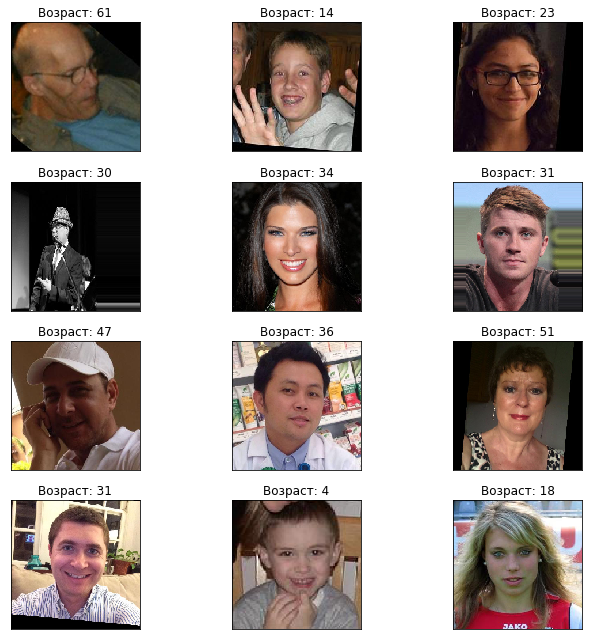

In [55]:
features, target = next(train_gen_flow)

# выводим 12 изображений

fig = plt.figure(figsize=(12,9))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(features[i])
    plt.title('Возраст: ' + str(target[i]))
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В наборе есть черно-белые и цветные фотографии с черными полями. 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=12345)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

<b>Результат обучения</b>

```
2021-03-26 11:24:22.765818: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2021-03-26 11:24:22.767686: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2021-03-26 11:24:23.861800: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-03-26 11:24:24.486697: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-03-26 11:24:24.486801: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-03-26 11:24:24.486840: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-03-26 11:24:24.488866: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-03-26 11:24:24.489235: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-03-26 11:24:24.491657: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-03-26 11:24:24.492898: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-03-26 11:24:24.492978: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-03-26 11:24:24.496561: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-03-26 11:24:24.496955: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-03-26 11:24:24.504315: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2021-03-26 11:24:24.504919: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4b31b60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-03-26 11:24:24.504944: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-03-26 11:24:24.629203: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4bb7b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-03-26 11:24:24.629250: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2021-03-26 11:24:24.631389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-03-26 11:24:24.631480: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-03-26 11:24:24.631494: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-03-26 11:24:24.631526: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-03-26 11:24:24.631541: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-03-26 11:24:24.631572: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-03-26 11:24:24.631598: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-03-26 11:24:24.631608: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-03-26 11:24:24.635399: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-03-26 11:24:24.635484: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-03-26 11:24:24.969150: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-03-26 11:24:24.969239: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2021-03-26 11:24:24.969249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2021-03-26 11:24:24.973045: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/10
2021-03-26 11:24:38.214192: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-03-26 11:24:38.571468: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 54s - loss: 196.1013 - mae: 10.3328 - val_loss: 753.2052 - val_mae: 22.4828
Epoch 2/10
356/356 - 44s - loss: 69.8223 - mae: 6.3948 - val_loss: 141.8774 - val_mae: 9.2494
Epoch 3/10
356/356 - 44s - loss: 37.3337 - mae: 4.7310 - val_loss: 93.8001 - val_mae: 7.7059
Epoch 4/10
356/356 - 44s - loss: 23.8102 - mae: 3.7633 - val_loss: 93.5009 - val_mae: 7.5901
Epoch 5/10
356/356 - 44s - loss: 17.0603 - mae: 3.1704 - val_loss: 71.6386 - val_mae: 6.3482
Epoch 6/10
356/356 - 44s - loss: 13.0826 - mae: 2.7855 - val_loss: 73.0537 - val_mae: 6.6404
Epoch 7/10
356/356 - 44s - loss: 11.5731 - mae: 2.5819 - val_loss: 70.5366 - val_mae: 6.2462
Epoch 8/10
356/356 - 44s - loss: 11.5076 - mae: 2.5564 - val_loss: 65.6032 - val_mae: 6.2167
Epoch 9/10
356/356 - 44s - loss: 10.4440 - mae: 2.4429 - val_loss: 72.7380 - val_mae: 6.4028
Epoch 10/10
356/356 - 44s - loss: 10.4240 - mae: 2.4196 - val_loss: 67.0686 - val_mae: 6.2882
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 67.0686 - mae: 6.2882
Test MAE: 6.2882



```

## Вывод
    

- Данные загружены и проанализированы.
- Построена модель на Resnet50 и предобучена на ImageNet. В модель добавлена аугментация.
- MAE модели меньше 8. MAE = 6.2882, что уловлетворяет заданию.
